In [2]:
# %% [code]
# 导入所需库
import os
import glob
import random
import jieba
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re

from gensim import corpora, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

In [3]:
# 设置日志级别
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# %% [code]
# ---------------------------
# 参数设置（均以变量形式提供，方便调试）
# ---------------------------

# 数据集相关
DATA_FOLDER = "D:\小说数据集"          # 本地存放 txt 文件的文件夹路径（请根据实际情况修改）
STOPWORDS_FILE = "cn_stopwords.txt"       # 停用词文件路径（每行一个停用词）
#SAMPLE_SIZE = 100                       # 从语料库中抽取的段落数量
SAMPLE_SIZE = 1000                       # 从语料库中抽取的段落数量
#K_VALUES = [20, 100, 500, 1000, 3000]      # 每个段落截取的 token 数
K_VALUES = [20, 100, 500, 1000, 3000]      # 每个段落截取的 token 数

# LDA 模型相关参数
#LDA_NUM_TOPICS = 20                      # 初始主题数量 T（可调参数或在循环中传入不同的 T 值）
#LDA_ITERATIONS = 1000                    # 迭代次数

LDA_NUM_TOPICS = 10                      # 初始主题数量 T（可调参数或在循环中传入不同的 T 值）
LDA_ITERATIONS = 100                    # 迭代次数

LDA_ALPHA = 'auto'                       # 可调参数
LDA_BETA = 'auto'                        # gensim中参数名称为 eta，可用'auto' 或数值

# 分类器相关参数
SVM_KERNEL = 'linear'
SVM_C = 1.0

# 实验相关参数
N_SPLITS = 10   # 10折交叉验证

# 可选参数：LDA 主题数量列表（若需要对比不同主题数量效果）
LDA_TOPIC_LIST = [10, 20, 30, 50]


In [4]:
# ---------------------------
# 模块1：数据加载与段落抽取
# ---------------------------
def load_paragraphs_from_folder(folder_path, encoding="utf-8"):
    """
    从指定文件夹中加载所有 txt 文件（跳过 inf.txt 文件），
    每个文件中的段落以“全角空格空格”（U+3000 U+3000）和换行作为分隔符。
    使用文件名（去除扩展名）作为所属小说的标签。
    
    若使用指定编码读取失败，则尝试使用 gbk 编码并忽略错误。
    
    返回：
        [(paragraph_text, label), ...]
    """
    paragraphs = []
    txt_files = glob.glob(os.path.join(folder_path, "*.txt"))
    
    for file_path in txt_files:
        if os.path.basename(file_path) == "inf.txt":
            continue  # 跳过 inf.txt 文件
        
        label = os.path.splitext(os.path.basename(file_path))[0]
        try:
            with open(file_path, "r", encoding=encoding) as f:
                content = f.read()
        except UnicodeDecodeError:
            with open(file_path, "r", encoding="gbk", errors="ignore") as f:
                content = f.read()
        
        # 使用正则表达式：以换行符后跟两个或更多全角空格（U+3000）作为段落分隔符
        # r'\n[　]{2,}' 匹配换行符后至少两个全角空格
        raw_paras = re.split(r'\n[　]{2,}', content)
        # 过滤空段落，并去除首尾空白
        for para in raw_paras:
            para = para.strip()
            if para:
                paragraphs.append((para, label))
    print(paragraphs)
    print('ok')
    return paragraphs
def sample_paragraphs(paragraphs, sample_size=SAMPLE_SIZE):
    """
    从全部段落中随机抽取 sample_size 个段落
    """
    if len(paragraphs) < sample_size:
        logging.warning("语料库段落数量不足，返回所有段落")
        return paragraphs
    return random.sample(paragraphs, sample_size)

# %% [code]

In [5]:
# ---------------------------
# 模块2：预处理与分词
# ---------------------------
def load_stopwords(stopwords_file):
    """
    加载停用词列表，每行一个停用词
    """
    stopwords = set()
    if os.path.exists(stopwords_file):
        with open(stopwords_file, "r", encoding="utf-8") as f:
            for line in f:
                word = line.strip()
                if word:
                    stopwords.add(word)
    else:
        logging.warning("停用词文件不存在！")
    return stopwords

def tokenize_text(text, mode='word'):
    """
    对输入文本进行分词处理：
      - mode='word': 使用 jieba 进行中文分词
      - mode='char': 将每个汉字作为一个 token
    返回 token 列表
    """
    if mode == 'word':
        tokens = list(jieba.cut(text))
    elif mode == 'char':
        tokens = list(text)
    else:
        raise ValueError("tokenization mode 应该为 'word' 或 'char'")
    return tokens

def preprocess_paragraph(text, mode='word', stopwords=set(), K=None):
    """
    对段落文本进行预处理：
      1. 分词（按 mode 选择：'word' 或 'char'）
      2. 过滤停用词
      3. 根据 K 值截取前 K 个 token（若 K 为 None，则不截断）
    返回预处理后的 token 列表
    """
    tokens = tokenize_text(text, mode=mode)
    # 过滤停用词（若 token 为空字符串也过滤掉）
    tokens = [token for token in tokens if token.strip() and token not in stopwords]
    if K is not None:
        tokens = tokens[:K]
    return tokens

# %% [code]

In [6]:
# ---------------------------
# 模块3：构建数据集 & LDA 主题建模
# ---------------------------
def build_corpus(tokenized_texts):
    """
    根据预处理后的文本（token 列表列表）构建 gensim 字典和语料库
    """
    dictionary = corpora.Dictionary(tokenized_texts)
    # 可选：过滤极低频或过高频词汇
    # dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    return dictionary, corpus

def train_lda_model(corpus, dictionary, num_topics, iterations, alpha, beta):
    """
    训练 LDA 模型
    """
    lda_model = models.LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                iterations=iterations,
                                alpha=alpha,
                                eta=beta,  # gensim 中使用 eta 表示 beta
                                random_state=42)
    return lda_model

def get_topic_distribution(lda_model, corpus, num_topics):
    """
    对语料库中的每篇文档，提取完整的主题分布向量（长度为 num_topics）
    """
    topic_distributions = []
    for bow in corpus:
        doc_topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        # 按照 topic id 排序，提取概率值
        doc_topics = sorted(doc_topics, key=lambda x: x[0])
        topic_vec = [prob for tid, prob in doc_topics]
        topic_distributions.append(topic_vec)
    return np.array(topic_distributions)

# %% [code]

In [7]:
# ---------------------------
# 模块4：分类与交叉验证（使用 SVM）
# ---------------------------
def classify_with_svm(X, y, svm_kernel=SVM_KERNEL, svm_C=SVM_C, n_splits=N_SPLITS):
    """
    使用 SVM 进行分类，并采用 n_splits 折交叉验证。
    返回字典，包含各折次的评价指标以及平均指标。
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    all_reports = []
    fold = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        
        clf = SVC(kernel=svm_kernel, C=svm_C, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        report = classification_report(y_test, y_pred, output_dict=True)
        
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        all_reports.append(report)
        logging.info(f"Fold {fold}: Acc={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold += 1
        
    results = {
        "accuracy": np.mean(acc_list),
        "precision": np.mean(precision_list),
        "recall": np.mean(recall_list),
        "f1_score": np.mean(f1_list),
        "reports": all_reports
    }
    return results

# %% [code]

In [8]:
# ---------------------------
# 模块5：可视化结果
# ---------------------------
def plot_performance(metrics_df, title="分类性能对比"):
    """
    接收一个包含实验指标的 DataFrame，
    绘制折线图展示不同参数下的分类性能变化
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metrics_df, markers=True, dashes=False)
    plt.title(title)
    plt.xlabel("参数组合")
    plt.ylabel("指标数值")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# %% [code]

In [9]:
def run_experiment(data_folder=DATA_FOLDER,
                   stopwords_file=STOPWORDS_FILE,
                   sample_size=SAMPLE_SIZE,
                   k_values=K_VALUES,
                   token_modes=['word', 'char'],
                   lda_topic_list=LDA_TOPIC_LIST,
                   lda_iterations=LDA_ITERATIONS,
                   lda_alpha=LDA_ALPHA,
                   lda_beta=LDA_BETA,
                   svm_kernel=SVM_KERNEL,
                   svm_C=SVM_C,
                   n_splits=N_SPLITS):
    """
    运行整个实验流程：
      1. 加载数据并抽取段落
      2. 对于每种 token 化方式（词、字）和每个 K 值，
         a. 预处理文本
         b. 构建数据集
         c. 对每个候选的 LDA 主题数量 T，训练 LDA 模型，获取主题分布作为特征
         d. 利用 SVM 进行 10 折交叉验证分类，并记录评价指标
      3. 汇总所有结果并返回实验结果 DataFrame
    """
    # 加载所有段落数据
    print('data_folder:',data_folder)
    all_paragraphs = load_paragraphs_from_folder(data_folder)
    sampled_paragraphs = sample_paragraphs(all_paragraphs, sample_size=sample_size)
    texts, labels = zip(*sampled_paragraphs)
    stopwords = load_stopwords(stopwords_file)
    
    results_list = []
    
    # 循环两种 token 化方式
    for mode in token_modes:
        logging.info(f"开始实验：分词模式 = {mode}")
        # 针对每个 K 值
        for K in k_values:
            logging.info(f"当前 K = {K}")
            # 对所有段落进行预处理（截取前 K 个 token）
            tokenized_texts = [preprocess_paragraph(text, mode=mode, stopwords=stopwords, K=K)
                               for text in texts]
            # 构建 gensim 语料库
            dictionary, corpus = build_corpus(tokenized_texts)
            
            # 针对不同 LDA 主题数量 T 进行实验
            for num_topics in lda_topic_list:
                logging.info(f"训练 LDA 模型：主题数 T = {num_topics}")
                lda_model = train_lda_model(corpus, dictionary, num_topics=num_topics,
                                            iterations=lda_iterations, alpha=lda_alpha, beta=lda_beta)
                # 获取主题分布作为特征
                X = get_topic_distribution(lda_model, corpus, num_topics)
                # 将标签转为列表
                y = list(labels)
                # 分类实验（10折交叉验证）
                clf_results = classify_with_svm(X, y, svm_kernel=svm_kernel, svm_C=svm_C, n_splits=n_splits)
                
                # 记录结果
                result_entry = {
                    "token_mode": mode,
                    "K": K,
                    "num_topics": num_topics,
                    "accuracy": clf_results["accuracy"],
                    "precision": clf_results["precision"],
                    "recall": clf_results["recall"],
                    "f1_score": clf_results["f1_score"]
                }
                results_list.append(result_entry)
                logging.info(f"结果: {result_entry}")
    
    results_df = pd.DataFrame(results_list)
    return results_df

2025-03-26 10:59:54,917 : INFO : 开始实验：分词模式 = word
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2025-03-26 10:59:54,954 : INFO : 当前 K = 20
Building prefix dict from the default dictionary ...
2025-03-26 10:59:55,029 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Dell\AppData\Local\Temp\jieba.cache
2025-03-26 10:59:55,039 : DEBUG : Loading model from cache C:\Users\Dell\AppData\Local\Temp\jieba.cache
Loading model cost 0.636 seconds.
2025-03-26 10:59:55,674 : DEBUG : Loading model cost 0.636 seconds.
Prefix dict has been built successfully.
2025-03-26 10:59:55,675 : DEBUG : Prefix dict has been built successfully.
2025-03-26 10:59:56,565 : INFO : adding document #0 to

实验结果汇总:
   token_mode     K  num_topics  accuracy  precision    recall  f1_score
0        word    20          10     0.197   0.030143  0.067588  0.036451
1        word    20          20     0.189   0.035610  0.068583  0.045203
2        word    20          30     0.188   0.031204  0.065474  0.040504
3        word    20          50     0.182   0.053167  0.068248  0.050804
4        word   100          10     0.196   0.038564  0.070102  0.046784
5        word   100          20     0.179   0.033707  0.063787  0.041363
6        word   100          30     0.177   0.040769  0.065688  0.047287
7        word   100          50     0.210   0.054038  0.081265  0.060518
8        word   500          10     0.190   0.041769  0.069036  0.045592
9        word   500          20     0.205   0.039333  0.074723  0.050508
10       word   500          30     0.200   0.045392  0.073008  0.050773
11       word   500          50     0.167   0.036104  0.061602  0.043893
12       word  1000          10     0.216  

C:\Users\Dell\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Dell\anaconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21516 (\N{CJK UNIF

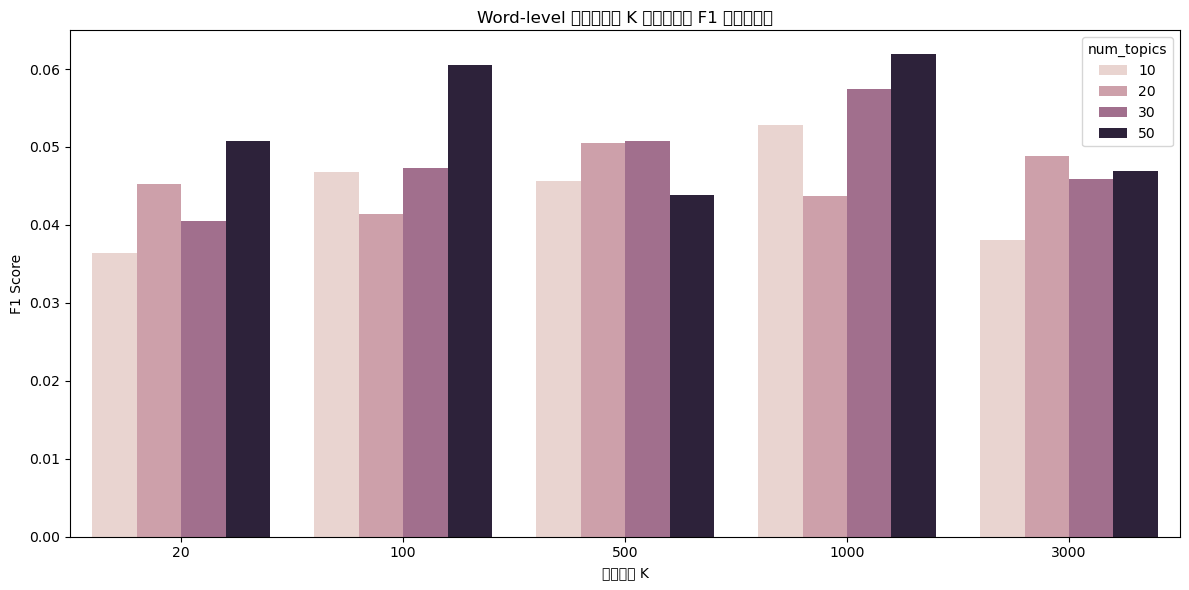

2025-03-26 11:01:54,308 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-26 11:01:54,313 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Dell\AppData\Local\Temp\ipykernel_6920\2380748013.py:32: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_6920\2380748013.py:32: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_6920\2380748013.py:32: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipyke

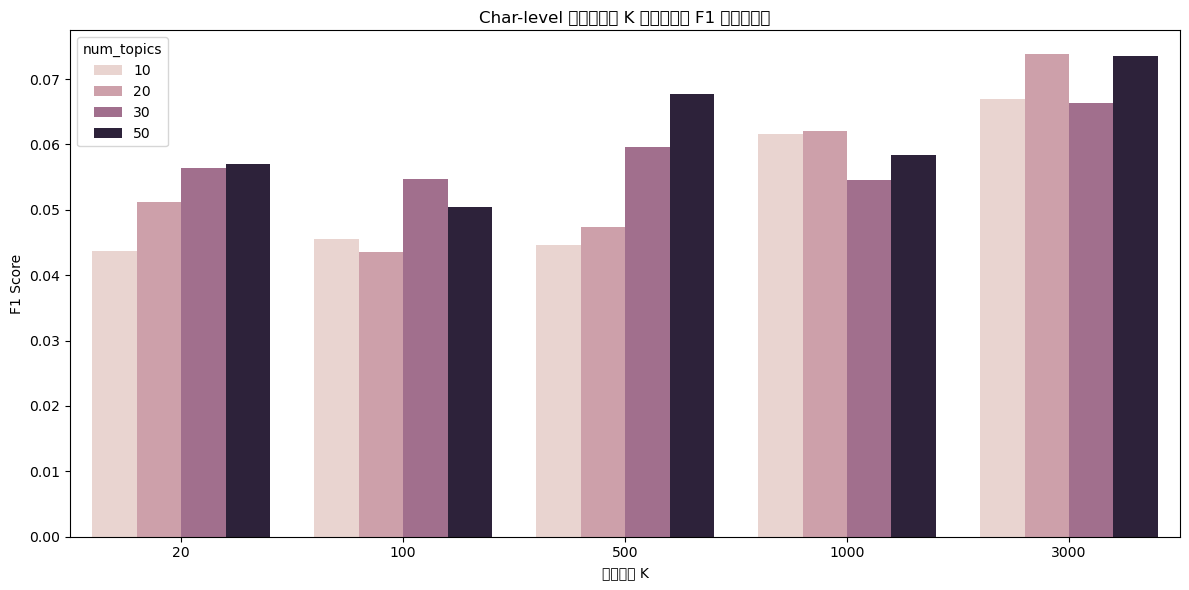

In [10]:

# %% [code]
# ---------------------------
# 主入口：运行实验、保存结果、可视化
# ---------------------------
if __name__ == '__main__':
    # 运行实验，返回结果 DataFrame
    results_df = run_experiment()
    
    # 显示结果表格
    print("实验结果汇总:")
    print(results_df)
    
    # 保存结果到 CSV 文件（可选）
    results_df.to_csv("experiment_results.csv", index=False)
    
    # 生成可视化图表（例如对不同 K 和主题数下的 F1 分数进行对比）
    # 可以根据需要进行更多自定义图表绘制
    plt.figure(figsize=(12, 6))
    sns.barplot(x="K", y="f1_score", hue="num_topics", data=results_df[results_df['token_mode'] == 'word'])
    plt.title("Word-level 分词下不同 K 与主题数对 F1 分数的影响")
    plt.xlabel("文本长度 K")
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.show()
    
    # 同理，可以绘制字符级别分词的对比图
    plt.figure(figsize=(12, 6))
    sns.barplot(x="K", y="f1_score", hue="num_topics", data=results_df[results_df['token_mode'] == 'char'])
    plt.title("Char-level 分词下不同 K 与主题数对 F1 分数的影响")
    plt.xlabel("文本长度 K")
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.show()
    
    # 其他指标的对比图和混淆矩阵的绘制也可以按照需要添加到实验报告中。